# INM702 : Mathematics and Programming for AI

## Task 3

#### Importing PyTorch and relevant libraries, running on CUDA, importing the MNIST dataset:

In [61]:
# Import libaries
import os
import torch
import  torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import time


In [62]:
# Set path for exporting results and figures:
path= "C:/Users/sarah/Documents/MSc AI 2020_2021/INM702/INM702_Mathematics_Programming_AI/"

In [63]:
#Check if GPU is available on device, set to use:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.get_device_name(0)
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [64]:
# Set up training vs test datasets based on a transform type, default is transform to tensor and normalize. 
# Resize is used to transform the dataset with use with ResNet model.

def transformed_data(resize=False):
   
    if(resize):
        transform=transforms.Compose([
                              transforms.Resize((224, 224)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5),(0.5))
                              ])
    else:
        transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5),(0.5))])
        
    train_dataset= datasets.MNIST(root='./data',
                              train=True,download=True,transform=transform)
    
    test_dataset= datasets.MNIST(root='./data',
                              train=False,download=True,transform=transform)
    return train_dataset, test_dataset

#### Creation of Training/Validation and Prediction methods:

In [65]:
# Creating a different Training/Validation method:
def train(model, optimiser, loss_function, train_loader, val_loader,epochs, device='cuda:0'):
    
    start_time=time.time()
    train_loss_history=[]
    val_loss_history=[]
    train_accuracy_history=[]
    val_accuracy_history=[]

    for e in range(epochs):
       
        # Run training steps
        model.train()
        train_loss=0
        val_loss=0
        train_num_images=0
        train_num_correct=0
        for batch, (inputs, targets) in enumerate (train_loader):
            batch+=1 # Start batch at 1
            inputs=inputs.to(device)
            targets=targets.to(device)
            outputs= model(inputs)
            loss = loss_function(outputs, targets)
            # Below flow, zero gradients from every step, compute derivative of the loss, step and update weights based on gradients
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            # update training loss
            train_loss+= loss.data.item()
            train_predicted = torch.max(outputs,1)[1]  # maximum probability, transform to class number. (index of maximum probability value)
            train_num_correct += torch.sum(train_predicted == targets.data)
            train_num_images+=train_predicted.shape[0]           
        train_loss/= len(train_loader)
        train_loss_history.append(train_loss)
        train_accuracy= train_num_correct/train_num_images
        train_accuracy_history.append(train_accuracy)
            
        
        # Run validation steps
       # Using model.eval() mode with batches for compute efficiency to run validation set    
        model.eval() # runs the model in evaluation model eg. will turn off dropout layers etc in nn.module
        val_num_correct=0
        val_num_images=0
        batch=0
        for batch, (inputs,targets) in enumerate (val_loader):
            batch+=1 # Start batch at 1
            inputs=inputs.to(device)
            targets=targets.to(device)
            outputs= model(inputs)
            loss = loss_function(outputs, targets)
            val_loss+= loss.data.item()          
            val_predicted = torch.max(outputs,1)[1]  # maximum probability, transform to class number. (index of maximum probability value)
            val_num_correct += torch.sum(val_predicted == targets.data)
            val_num_images+=val_predicted.shape[0]
        val_loss/= len(val_loader)  
        val_loss_history.append(val_loss)
        val_accuracy= val_num_correct/val_num_images
        val_accuracy_history.append(val_accuracy)
        total_time = time.time()- start_time
            
         
        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss:{:.4f}, train_accuracy = {:.4f}, val_accuracy = {:.4f}'
              .format(e,  train_loss, val_loss, train_accuracy, val_accuracy))
    print('Duration:{} seconds'.format(total_time))
    performance_history = {}
    performance_history['train_loss']=train_loss_history
    performance_history['val_loss']=val_loss_history
    performance_history['train_accuracy']=train_accuracy_history
    performance_history['val_accuracy']=val_accuracy_history
    performance_history['total_time']=total_time
    return performance_history



In [66]:
# Defining a predicition method for test datasets:

def predict(model, test_loader, device):
    with torch.no_grad(): # ensure that we turn off gradient computation
        model.eval() # runs the model in evaluation model eg. will turn off dropout layers etc in nn.module
        predictions=torch.tensor([]).to(device)
        test_num_correct=0
        test_num_images=0
        test_loss=0
        start_time=time.time()
        batch=0
        for batch, (inputs,targets) in enumerate (test_loader):
            batch+=1 # Start batch at 1
            inputs=inputs.to(device)
            targets=targets.to(device)
            outputs= model(inputs)
            loss = loss_function(outputs, targets)
            test_loss+= loss.data.item()          
            test_predicted = torch.max(outputs,1)[1]  # maximum probability, transform to class number. (index of maximum probability value)
            predictions=torch.cat((predictions, test_predicted), dim=0)
            test_num_correct += torch.sum(test_predicted == targets.data)
            test_num_images+=test_predicted.shape[0]
        predictions
        test_loss/= len(test_loader)  
        test_accuracy= test_num_correct/test_num_images
        total_time = time.time()- start_time
        print('Duration:{} seconds'.format(total_time))
        performance = {}
        performance['test_loss']=test_loss
        performance['test_accuracy']=test_accuracy
        return performance, predictions

#### Setting up functions to plot our results for loss, accuracy and functions to create and plot a confusion matrix for our test predictions:

In [67]:
# Define functions to run plots

def plot_train_loss(history, title):
    fig= plt.figure()
    plt.plot((history['train_loss']), label='Training Loss')
    plt.plot((history['val_loss']), label='Validation Loss')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig 

def plot_train_accuracy(history, title):
    fig= plt.figure()
    plt.plot((history['train_accuracy']), label='Train accuracy')
    plt.plot((history['val_accuracy']), label='Validation accuracy')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig 

def confusion_matrix(predictions, test_dataset):
    pred=predictions
    actual=test_dataset.targets.to(device)
    actual_pred = torch.stack((actual, pred), dim=1)
    confusion_matrix = torch.zeros(10,10, dtype=torch.int32)
    for result in actual_pred.long():
        true, predicted = result.tolist()
        confusion_matrix[true,predicted] += 1
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix, title):
    CM=confusion_matrix.numpy()
    fig=plt.figure()
    plt.imshow(CM, cmap=plt.cm.Blues, vmax=30)
    plt.title(title)
    classes=[0,1,2,3,4,5,6,7,8,9]
    tick_marks = np.arange(len(classes))
    for i in range(CM.shape[0]):
            for j in range(CM.shape[1]):
                plt.text(j, i, format(CM[i, j]), fontsize=8,
                         ha="center", va="center",
                         color="white" if CM[i,j]>50 else "black")
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig




#### Creating the neural network classes for exploration:

In [68]:
# Simple artificial neural network:

class NeuralNetwork(nn.Module): # inherits from nn.module
    def __init__(self, n_input, n_layer1, n_layer2, n_output,activation_functions):
        super().__init__()   # to instantiate the nn.module (R)

        # initialise layers of neural network and specifiy sizes
        self.fc_layer1= nn.Linear(n_input, n_layer1)
        self.fc_layer2= nn.Linear(n_layer1, n_layer2)
        self.output_layer= nn.Linear(n_layer2, n_output)
        self.activation_functions = activation_functions
        # Forward pass needs to specifiy connections of the initialised layers (sigmoid and relu)
    def forward(self, X):
        X=X.view(X.shape[0],-1) # Flattens the image 
        if(self.activation_functions[0]=='Sigmoid'):
            X= F.sigmoid(self.fc_layer1(X))
        elif(self.activation_functions[0]=='ReLu'):
            X= F.relu(self.fc_layer1(X))
        else:
            print(self.activation_functions[0])
            raise ValueError("activation function not recognized")
        
        if(self.activation_functions[1]=='Sigmoid'):
            X= F.sigmoid(self.fc_layer2(X))
        elif(self.activation_functions[1]=='ReLu'):
            X= F.relu(self.fc_layer2(X))
        else:
            print(self.activation_functions[0])
            raise ValueError("activation function not recognized")
            
        X=self.output_layer(X) # CrossEntropyLoss already contains SoftMax so it won't be applied to output layer.
        return X


In [69]:
# Simple artificial neural network with dropout layers applied:
class NeuralNetwork_Dropout(nn.Module): # inherits from nn.module
    def __init__(self, n_input, n_layer1, n_layer2, n_output, activation_functions,p):
        super().__init__()   # to instantiate the nn.module (R)

        self.fc_layer1= nn.Linear(n_input, n_layer1)
        self.dropout1=nn.Dropout(p=p)
        self.fc_layer2= nn.Linear(n_layer1, n_layer2)
        self.dropout2=nn.Dropout(p=p)
        self.output_layer= nn.Linear(n_layer2, n_output)
        self.activation_functions = activation_functions
        # Forward pass needs to specifiy connections of the initialised layers (sigmoid and relu)
    def forward(self, X):
        X=X.view(X.shape[0],-1) # Flattens 
        if(self.activation_functions[0]=='Sigmoid'):
            X= F.sigmoid(self.fc_layer1(X))
        elif(self.activation_functions[0]=='ReLu'):
            X= F.relu(self.fc_layer1(X))
        else:
            print(self.activation_functions[0])
            raise ValueError("activation function not recognized")
            
        X= self.dropout1(X)
        
        if(self.activation_functions[1]=='Sigmoid'):
            X= F.sigmoid(self.fc_layer2(X))
        elif(self.activation_functions[1]=='ReLu'):
            X= F.relu(self.fc_layer2(X))
        else:
            print(self.activation_functions[0])
            raise ValueError("activation function not recognized")
            
        X= self.dropout2(X)
        X=self.output_layer(X) # CrossEntropyLoss already contains SoftMax so it won't be applied to output layer.
        return X 

#### Creating the CNN classes, basic CNN and ResNet CNN based for transfer learning:

In [70]:
# Convolutional Neural Network Model:
class ConvNetwork(nn.Module):
    
    def __init__(self,n_layer1, n_layer2, n_output, activation_functions,n_clayer1=20,n_clayer2=80):
        super().__init__()
        self.conv_layer1 = nn.Conv2d(1, n_clayer1, kernel_size=3, stride=1)
        self.conv_layer2= nn.Conv2d(n_clayer1, n_clayer2, kernel_size=3, stride=1)
        self.fc_layer1= nn.Linear(5*5*n_clayer2, n_layer1)
        self.fc_layer2= nn.Linear(n_layer1,n_layer2)
        self.output_layer= nn.Linear(n_layer2,n_output)
        self.activation_functions = activation_functions
        self.n_c_output = n_clayer2
        
    def forward(self, X): 
        X= F.relu(self.conv_layer1(X)) 
        X= F.max_pool2d(X, 2, 2) # Reduce the image in half
        X= F.relu(self.conv_layer2(X)) 
        X= F.max_pool2d(X,2,2) 
        X= X.view(-1, 5*5*self.n_c_output) # Flatten the image to pass through the fc layers     
        if(self.activation_functions[0]=='Sigmoid'):
            X= F.sigmoid(self.fc_layer1(X))
        elif(self.activation_functions[0]=='ReLu'):
            X= F.relu(self.fc_layer1(X))
        else:
            print(self.activation_functions[0])
            raise ValueError("activation function not recognized")
            
        if(self.activation_functions[1]=='Sigmoid'):
            X= F.sigmoid(self.fc_layer2(X))
        elif(self.activation_functions[1]=='ReLu'):
            X= F.relu(self.fc_layer2(X))
        else:
            print(self.activation_functions[0])
            raise ValueError("activation function not recognized")
            
        X= self.output_layer(X)
        return X



In [71]:
# Exploring Transfer Learning with  ResNet-18:

# Load pre-trained model from pyTorch

ResNet= models.resnet18(pretrained=True)

# Visualise ResNet model
#print(ResNet)
       
 # Change input layer to take in a single input and final block layer to output 10 neurons in line with MNIST classes 
ResNet.conv1= nn.Sequential(nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False))
ResNet.fc= nn.Sequential(nn.Linear(512, 10)) 

# Check model changes
print(ResNet)

   

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rel

#### ANN neural network training and testing, generating architectures for comparison to Task 2:

NeuralNetwork(
  (fc_layer1): Linear(in_features=784, out_features=512, bias=True)
  (fc_layer2): Linear(in_features=512, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)


C:\Users\sarah\anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, Training Loss: 0.5885, Validation Loss:0.2634, train_accuracy = 0.8418, val_accuracy = 0.9222
Epoch: 1, Training Loss: 0.2084, Validation Loss:0.1962, train_accuracy = 0.9394, val_accuracy = 0.9434
Epoch: 2, Training Loss: 0.1439, Validation Loss:0.1479, train_accuracy = 0.9576, val_accuracy = 0.9555
Epoch: 3, Training Loss: 0.1072, Validation Loss:0.1188, train_accuracy = 0.9681, val_accuracy = 0.9640
Epoch: 4, Training Loss: 0.0847, Validation Loss:0.1227, train_accuracy = 0.9742, val_accuracy = 0.9630
Epoch: 5, Training Loss: 0.0672, Validation Loss:0.1073, train_accuracy = 0.9799, val_accuracy = 0.9680
Epoch: 6, Training Loss: 0.0571, Validation Loss:0.1074, train_accuracy = 0.9827, val_accuracy = 0.9681
Epoch: 7, Training Loss: 0.0482, Validation Loss:0.0876, train_accuracy = 0.9856, val_accuracy = 0.9755
Epoch: 8, Training Loss: 0.0416, Validation Loss:0.0949, train_accuracy = 0.9872, val_accuracy = 0.9719
Epoch: 9, Training Loss: 0.0336, Validation Loss:0.0922, train_a

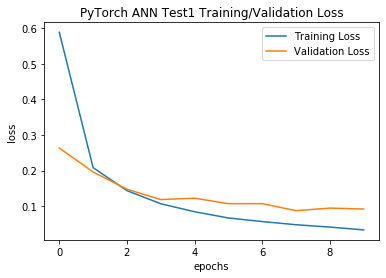

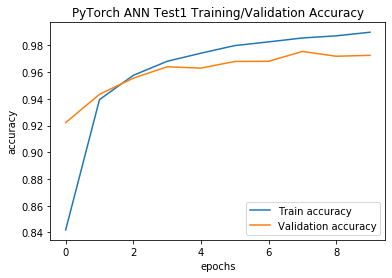

In [73]:
# Train PyTorch neural network class NeuralNetwork Test 1 [784, 512, 128, 10, [Sigmoid,Sigmoid]]: 

# Instantiate the model and move to run on GPU:
torch.manual_seed(10)
# input neurons(should be 784 based on MNIST pixels)
# In our initial test we compare to our results from Task2 for the following architecture (784,[512,128],10, [Sigmoid,Sigmoid].
# Need to pass  n_input, n_layer1, n_layer2, n_output, [activation_functions]
modeltest1= NeuralNetwork(784, 512, 128, 10, activation_functions=['Sigmoid', 'Sigmoid']) 
modeltest1.to("cuda:0")
print(modeltest1)
      
# Set hyperparameters
batch_size=100 #Set batch size for loaders
loss_function= nn.CrossEntropyLoss()
learning_rate=0.001
optimiser= torch.optim.Adam(modeltest1.parameters(),lr=learning_rate)  
epochs=10
device= "cuda:0"
    
# Call transformed data
ANN_train_dataset, ANN_test_dataset=transformed_data()
   
# Create validation subset and set up the dataset loaders

train_subset, validation_subset = torch.utils.data.random_split(
        ANN_train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(10))

train_loader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
val_loader= DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
test_loader= DataLoader(ANN_test_dataset, batch_size=batch_size, shuffle=False) 

# Run Train/Validate for the instantiated model and record performance
# model, optimiser, loss_function, train_loader, val_loader, epochs, device
ANN_performance_history_test1 = train(model=modeltest1, optimiser=optimiser, loss_function=loss_function, train_loader=train_loader, val_loader=val_loader, 
              epochs=epochs, device=device)

# Plot loss and accuracy curves # requires history, title
                                  
fig= plot_train_loss(ANN_performance_history_test1, "PyTorch ANN Test1 Training/Validation Loss")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Test1_Training_Validation_Loss.jpg'), dpi=200)


fig=plot_train_accuracy(ANN_performance_history_test1, "PyTorch ANN Test1 Training/Validation Accuracy")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Test1_Training_Validation_Accuracy.jpg'), dpi=200)
plt.close;
                                   


C:\Users\sarah\anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Duration:2.118044376373291 seconds
Test loss for ANN Test1 is 0.0880044286926568
Test accuracy % for ANN Test1 is 97.36000061035156
Error rate % for ANN Test1 is 2.640002965927124


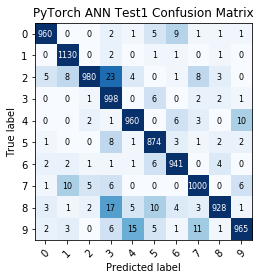

In [74]:
# ANN Test 1 results:

# Reload test dataset

ANN_train_dataset, ANN_test_dataset=transformed_data()
test_loader= DataLoader(ANN_test_dataset, batch_size=batch_size, shuffle=False) 

# Predict test set
ANN_test1_results, ANN_test1_predictions = predict(model=modeltest1, test_loader=test_loader, device=device)

# Print results
print('Test loss for ANN Test1 is {}'.format(ANN_test1_results['test_loss']))
print('Test accuracy % for ANN Test1 is {}'.format((ANN_test1_results['test_accuracy']*100)))
print('Error rate % for ANN Test1 is {}'.format((1-ANN_test1_results['test_accuracy'])*100))

# Create and plot Confusion Matrix

ANN_CM_test1= confusion_matrix(ANN_test1_predictions, ANN_test_dataset) # requires predictions & test_dataset

fig= plot_confusion_matrix (ANN_CM_test1, "PyTorch ANN Test1 Confusion Matrix");
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Test1_Confusion_Matrix.jpg'), dpi=200)

NeuralNetwork(
  (fc_layer1): Linear(in_features=784, out_features=512, bias=True)
  (fc_layer2): Linear(in_features=512, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 0, Training Loss: 0.4857, Validation Loss:0.2624, train_accuracy = 0.8570, val_accuracy = 0.9207
Epoch: 1, Training Loss: 0.2056, Validation Loss:0.1898, train_accuracy = 0.9398, val_accuracy = 0.9442
Epoch: 2, Training Loss: 0.1416, Validation Loss:0.1567, train_accuracy = 0.9578, val_accuracy = 0.9535
Epoch: 3, Training Loss: 0.1063, Validation Loss:0.1200, train_accuracy = 0.9681, val_accuracy = 0.9658
Epoch: 4, Training Loss: 0.0861, Validation Loss:0.1186, train_accuracy = 0.9730, val_accuracy = 0.9651
Epoch: 5, Training Loss: 0.0696, Validation Loss:0.1251, train_accuracy = 0.9777, val_accuracy = 0.9658
Epoch: 6, Training Loss: 0.0606, Validation Loss:0.1074, train_accuracy = 0.9809, val_accuracy = 0.9684
Epoch: 7, Training Loss: 0.0494, Validation Loss:

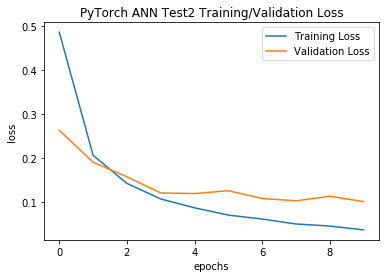

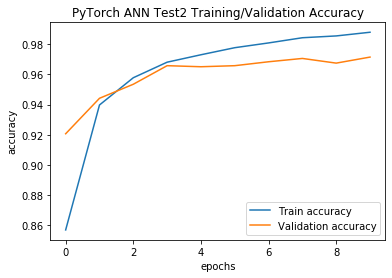

In [75]:
# Train PyTorch neural network class NeuralNetwork Test 2 [784, 512, 128, 10, [Sigmoid,ReLu]]: 

# Instantiate the model and move to run on GPU:
torch.manual_seed(10)
# input neurons(should be 784 based on MNIST pixels)
# In our initial test we compare to our results from Task2 for the following architecture (784,[512,128],10, [Sigmoid,ReLu].
# Need to pass  n_input, n_layer1, n_layer2, n_output, [activation_functions]
modeltest2= NeuralNetwork(784, 512, 128, 10, activation_functions=['Sigmoid', 'ReLu']) 
modeltest2.to("cuda:0")
print(modeltest2)
      
# Set hyperparameters
batch_size=100 #Set batch size for loaders
loss_function= nn.CrossEntropyLoss()
learning_rate=0.001
optimiser= torch.optim.Adam(modeltest2.parameters(),lr=learning_rate)  
epochs=10
device= "cuda:0"
    
# Call transformed data
ANN_train_dataset, ANN_test_dataset=transformed_data()
   
# Create validation subset and set up the dataset loaders

train_subset, validation_subset = torch.utils.data.random_split(
        ANN_train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(10))

train_loader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
val_loader= DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
test_loader= DataLoader(ANN_test_dataset, batch_size=batch_size, shuffle=False) 

# Run Train/Validate for the instantiated model and record performance
# model, optimiser, loss_function, train_loader, val_loader, epochs, device
ANN_performance_history_test2 = train(model=modeltest2, optimiser=optimiser, loss_function=loss_function, train_loader=train_loader, val_loader=val_loader, 
              epochs=epochs, device=device)

# Plot loss and accuracy curves # requires history, title
                                   
fig=plot_train_loss(ANN_performance_history_test2, "PyTorch ANN Test2 Training/Validation Loss")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Test2_Training_Validation_Loss.jpg'), dpi=200)

fig=plot_train_accuracy(ANN_performance_history_test2, "PyTorch ANN Test2 Training/Validation Accuracy")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Test2_Training_Validation_Accuracy.jpg'), dpi=200)
plt.close;
                              

Duration:1.3245010375976562 seconds
Test loss for ANN Test2 is 0.08708048523345496
Test accuracy % for ANN Test2 is 97.38999938964844
Error rate % for ANN Test2 is 2.61000394821167


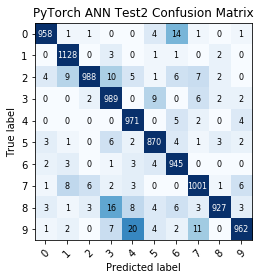

In [77]:
# ANN Test 2 results:

# Reload test dataset

ANN_train_dataset, ANN_test_dataset=transformed_data()
test_loader= DataLoader(ANN_test_dataset, batch_size=batch_size, shuffle=False) 

# Predict test set
ANN_test2_results, ANN_test2_predictions = predict(model=modeltest2, test_loader=test_loader, device=device)

# Print results
print('Test loss for ANN Test2 is {}'.format(ANN_test2_results['test_loss']))
print('Test accuracy % for ANN Test2 is {}'.format((ANN_test2_results['test_accuracy']*100)))
print('Error rate % for ANN Test2 is {}'.format((1-ANN_test2_results['test_accuracy'])*100))

# Create and plot Confusion Matrix

ANN_CM_test2= confusion_matrix(ANN_test2_predictions, ANN_test_dataset) # requires predictions & test_dataset

fig=plot_confusion_matrix (ANN_CM_test2, "PyTorch ANN Test2 Confusion Matrix")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Test2_Confusion_Matrix.jpg'), dpi=200);

#### ANN neural network with dropout training & testing:

NeuralNetwork_Dropout(
  (fc_layer1): Linear(in_features=784, out_features=512, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc_layer2): Linear(in_features=512, out_features=128, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 0, Training Loss: 0.5421, Validation Loss:0.2675, train_accuracy = 0.8352, val_accuracy = 0.9193
Epoch: 1, Training Loss: 0.2448, Validation Loss:0.1853, train_accuracy = 0.9272, val_accuracy = 0.9440
Epoch: 2, Training Loss: 0.1783, Validation Loss:0.1565, train_accuracy = 0.9462, val_accuracy = 0.9523
Epoch: 3, Training Loss: 0.1423, Validation Loss:0.1213, train_accuracy = 0.9565, val_accuracy = 0.9637
Epoch: 4, Training Loss: 0.1203, Validation Loss:0.1177, train_accuracy = 0.9634, val_accuracy = 0.9620
Epoch: 5, Training Loss: 0.1028, Validation Loss:0.0983, train_accuracy = 0.9679, val_accuracy = 0.9701
Epoch: 6, Training Loss: 0.0940, Validation Loss:0.1017, 

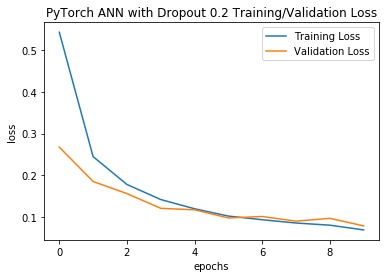

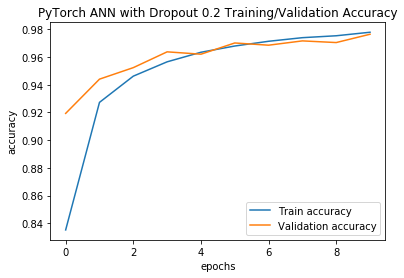

In [78]:
# Train PyTorch neural network class NeuralNetwork_Dropout to compare with ANN Test 2 architecture, p=0.2: 

# Instantiate the model and move to run on GPU:
torch.manual_seed(10)
# input neurons(should be 784 based on MNIST pixels), set p value for dropout percentage to test
# Need to pass  n_input, n_layer1, n_layer2, n_output, [activation_functions], p
model_ANN_D= NeuralNetwork_Dropout(784, 512, 128, 10, activation_functions=['Sigmoid', 'ReLu'], p=0.2) # default p is 0.5
model_ANN_D.to("cuda:0")
print(model_ANN_D)
      
# Set hyperparameters
batch_size=100 #Set batch size for loaders
loss_function= nn.CrossEntropyLoss()
learning_rate=0.001
optimiser= torch.optim.Adam(model_ANN_D.parameters(),lr=learning_rate)  
epochs=10
device= "cuda:0"
    
# Call transformed data
ANN_train_dataset, ANN_test_dataset= transformed_data()
    
# Create validation subset and set up the dataset loaders

train_subset, validation_subset = torch.utils.data.random_split(
        ANN_train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(10))
train_loader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
val_loader= DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
test_loader= DataLoader(ANN_test_dataset, batch_size=batch_size, shuffle=False) 

# Run Train/Validate for the instantiated model and record performance
# Set model, optimiser, loss_function, train_loader, val_loader, epochs, device
ANN_Dropout_performance_history = train(model=model_ANN_D, optimiser=optimiser, loss_function=loss_function, train_loader=train_loader, val_loader=val_loader, 
              epochs=epochs, device=device)

# Plot loss and accuracy curves # requires history, title
fig=plot_train_loss(ANN_Dropout_performance_history, "PyTorch ANN with Dropout 0.2 Training/Validation Loss")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Dropout_02_Training_Validation_Loss.jpg'), dpi=200)


fig=plot_train_accuracy(ANN_Dropout_performance_history, "PyTorch ANN with Dropout 0.2 Training/Validation Accuracy")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Dropout_02_Training_Validation_Accuracy.jpg'), dpi=200)
plt.close;
                                   


C:\Users\sarah\anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Duration:2.086625099182129 seconds
Test loss for ANN with Dropout 0.2 is 0.07682183700540918
Test accuracy % for ANN with Dropout 0.2 is 97.6199951171875
Error rate % for ANN with Dropout 0.2 is 2.3800015449523926


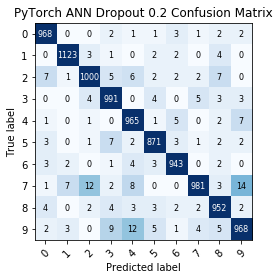

In [79]:
# ANN Dropout test result for p=0.2

# Reload test dataset

ANN_train_dataset, ANN_test_dataset=transformed_data()
test_loader= DataLoader(ANN_test_dataset, batch_size=batch_size, shuffle=False) 

# Predict test set
ANN_Dropout_test_results, ANN_Dropout_predictions = predict(model=model_ANN_D, test_loader=test_loader, device=device)

# # Print results
print('Test loss for ANN with Dropout 0.2 is {}'.format(ANN_Dropout_test_results['test_loss']))
print('Test accuracy % for ANN with Dropout 0.2 is {}'.format((ANN_Dropout_test_results['test_accuracy']*100)))
print('Error rate % for ANN with Dropout 0.2 is {}'.format((1-ANN_Dropout_test_results['test_accuracy'])*100))

# Create and plot Confusion Matrix
ANN_Dropout_CM= confusion_matrix(ANN_Dropout_predictions, ANN_test_dataset) # requires predictions & test_dataset
fig=plot_confusion_matrix (ANN_Dropout_CM, "PyTorch ANN Dropout 0.2 Confusion Matrix")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Dropout_02_Confusion_Matrix.jpg'), dpi=200);

NeuralNetwork_Dropout(
  (fc_layer1): Linear(in_features=784, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc_layer2): Linear(in_features=512, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 0, Training Loss: 0.6885, Validation Loss:0.2836, train_accuracy = 0.7835, val_accuracy = 0.9159
Epoch: 1, Training Loss: 0.3245, Validation Loss:0.2166, train_accuracy = 0.9051, val_accuracy = 0.9337
Epoch: 2, Training Loss: 0.2596, Validation Loss:0.1845, train_accuracy = 0.9246, val_accuracy = 0.9431
Epoch: 3, Training Loss: 0.2118, Validation Loss:0.1488, train_accuracy = 0.9378, val_accuracy = 0.9551
Epoch: 4, Training Loss: 0.1907, Validation Loss:0.1294, train_accuracy = 0.9440, val_accuracy = 0.9619
Epoch: 5, Training Loss: 0.1729, Validation Loss:0.1295, train_accuracy = 0.9489, val_accuracy = 0.9616
Epoch: 6, Training Loss: 0.1610, Validation Loss:0.1149, 

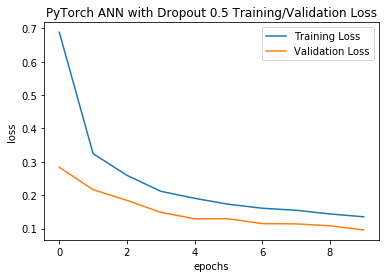

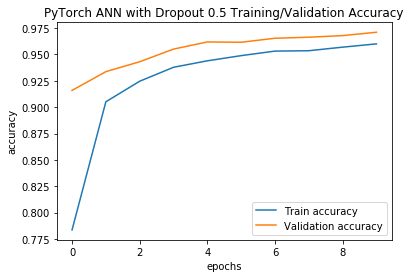

In [80]:
# Train PyTorch neural network class NeuralNetwork_Dropout to compare with ANN Test 2 architecture, p=0.5: 

# Instantiate the model and move to run on GPU:
torch.manual_seed(10)
# input neurons(should be 784 based on MNIST pixels), set p value for dropout percentage to test
# Need to pass  n_input, n_layer1, n_layer2, n_output, [activation_functions], p
model_ANN_D_t2= NeuralNetwork_Dropout(784, 512, 128, 10, activation_functions=['Sigmoid', 'ReLu'], p=0.5) # default p is 0.5
model_ANN_D_t2.to("cuda:0")
print(model_ANN_D_t2)
      
# Set hyperparameters
batch_size=100 #Set batch size for loaders
loss_function= nn.CrossEntropyLoss()
learning_rate=0.001
optimiser= torch.optim.Adam(model_ANN_D_t2.parameters(),lr=learning_rate)  
epochs=10
device= "cuda:0"
    
# Call transformed data
ANN_train_dataset, ANN_test_dataset= transformed_data()
    
# Create validation subset and set up the dataset loaders

train_subset, validation_subset = torch.utils.data.random_split(
        ANN_train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(10))
train_loader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
val_loader= DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
test_loader= DataLoader(ANN_test_dataset, batch_size=batch_size, shuffle=False) 

# Run Train/Validate for the instantiated model and record performance
# Set model, optimiser, loss_function, train_loader, val_loader, epochs, device
ANN_Dropout_performance_history_t2 = train(model=model_ANN_D_t2, optimiser=optimiser, loss_function=loss_function, train_loader=train_loader, val_loader=val_loader, 
              epochs=epochs, device=device)

# Plot loss and accuracy curves # requires history, title
fig= plot_train_loss(ANN_Dropout_performance_history_t2, "PyTorch ANN with Dropout 0.5 Training/Validation Loss")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Dropout_05_Training_Validation_Loss.jpg'), dpi=200)

fig=plot_train_accuracy(ANN_Dropout_performance_history_t2, "PyTorch ANN with Dropout 0.5 Training/Validation Accuracy")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Dropout_05_Training_Validation_Accuracy.jpg'), dpi=200)
plt.close;

C:\Users\sarah\anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Duration:1.290839433670044 seconds
Test loss for ANN with Dropout 0.5 is 0.0915392443969904
Test accuracy % for ANN with Dropout 0.5 is 97.22999572753906
Error rate % for ANN with Dropout 0.5 is 2.770000696182251


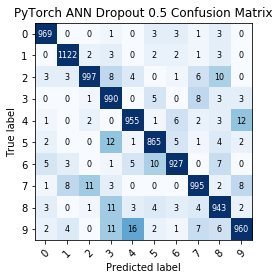

In [81]:
# ANN Dropout test result for p=0.5

# Reload test dataset

ANN_train_dataset, ANN_test_dataset=transformed_data()
test_loader= DataLoader(ANN_test_dataset, batch_size=batch_size, shuffle=False) 

# Predict test set
ANN_Dropout_test_results_t2, ANN_Dropout_predictions_t2 = predict(model=model_ANN_D_t2, test_loader=test_loader, device=device)

# # Print results
print('Test loss for ANN with Dropout 0.5 is {}'.format(ANN_Dropout_test_results_t2['test_loss']))
print('Test accuracy % for ANN with Dropout 0.5 is {}'.format((ANN_Dropout_test_results_t2['test_accuracy']*100)))
print('Error rate % for ANN with Dropout 0.5 is {}'.format((1-ANN_Dropout_test_results_t2['test_accuracy'])*100))

# Create and plot Confusion Matrix
ANN_Dropout_CM_t2= confusion_matrix(ANN_Dropout_predictions_t2, ANN_test_dataset) # requires predictions & test_dataset
fig=plot_confusion_matrix (ANN_Dropout_CM_t2, "PyTorch ANN Dropout 0.5 Confusion Matrix")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_Dropout_05_Confusion_Matrix.jpg'), dpi=200);

##### ANN with AdamW (Weight Decay - L2 regularization) train & test:

NeuralNetwork(
  (fc_layer1): Linear(in_features=784, out_features=512, bias=True)
  (fc_layer2): Linear(in_features=512, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 0, Training Loss: 0.4872, Validation Loss:0.2627, train_accuracy = 0.8568, val_accuracy = 0.9208
Epoch: 1, Training Loss: 0.2065, Validation Loss:0.1899, train_accuracy = 0.9391, val_accuracy = 0.9436
Epoch: 2, Training Loss: 0.1429, Validation Loss:0.1556, train_accuracy = 0.9575, val_accuracy = 0.9532
Epoch: 3, Training Loss: 0.1075, Validation Loss:0.1225, train_accuracy = 0.9674, val_accuracy = 0.9644
Epoch: 4, Training Loss: 0.0869, Validation Loss:0.1228, train_accuracy = 0.9729, val_accuracy = 0.9631
Epoch: 5, Training Loss: 0.0706, Validation Loss:0.1248, train_accuracy = 0.9775, val_accuracy = 0.9645
Epoch: 6, Training Loss: 0.0599, Validation Loss:0.1086, train_accuracy = 0.9804, val_accuracy = 0.9695
Epoch: 7, Training Loss: 0.0501, Validation Loss:

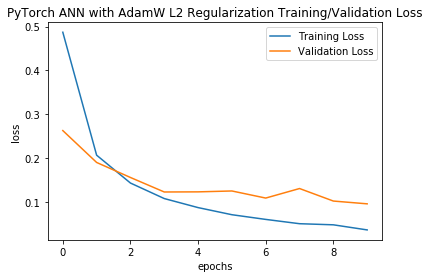

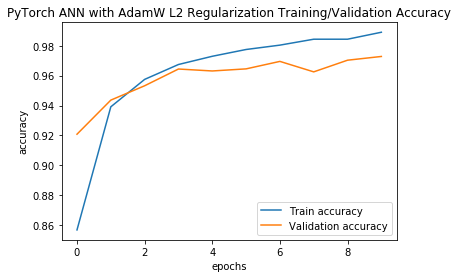

In [82]:
# Train PyTorch neural network class using Weight Decay - L2 penalty on Adam optimiser:

# Instantiate the model and move to run on GPU:
torch.manual_seed(10)
# input neurons(should be 784 based on MNIST pixels)
# In our initial test we compare to our results from Task2 for the following architecture (784,[512,128],10, [Sigmoid,ReLu].
ANN_L2= NeuralNetwork(784, 512, 128, 10, activation_functions=['Sigmoid', 'ReLu']) 
ANN_L2.to("cuda:0")
print(ANN_L2)
      
# Set hyperparameters
batch_size=100 #Set batch size for loaders
loss_function= nn.CrossEntropyLoss()
learning_rate=0.001
optimiser= torch.optim.AdamW(ANN_L2.parameters(),lr=learning_rate)  # Weight_decay default 0.01 in AdamW
epochs=10
device= "cuda:0"
    
# Call transformed data
ANN_train_dataset, ANN_test_dataset=transformed_data()
   
# Create validation subset and set up the dataset loaders

train_subset, validation_subset = torch.utils.data.random_split(
        ANN_train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(10))

train_loader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
val_loader= DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
test_loader= DataLoader(ANN_test_dataset, batch_size=batch_size, shuffle=False) 

# Run Train/Validate for the instantiated model and record performance
# model, optimiser, loss_function, train_loader, val_loader, epochs, device
ANN_L2_performance_history = train(model=ANN_L2, optimiser=optimiser, loss_function=loss_function, train_loader=train_loader, val_loader=val_loader, 
              epochs=epochs, device=device)

# Plot loss and accuracy curves # requires history, title
                                   
fig=plot_train_loss(ANN_L2_performance_history, "PyTorch ANN with AdamW L2 Regularization Training/Validation Loss")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_AdamW_Training_Validation_Loss.jpg'), dpi=200)

fig=plot_train_accuracy(ANN_L2_performance_history, "PyTorch ANN with AdamW L2 Regularization Training/Validation Accuracy")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_AdamW_Training_Validation_Accuracy.jpg'), dpi=200)
plt.close;
                                   

C:\Users\sarah\anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Duration:1.3436260223388672 seconds
Test loss for ANN is 0.08497424129454885
Test accuracy % for ANN is 97.43000030517578
Error rate % for ANN is 2.5700032711029053


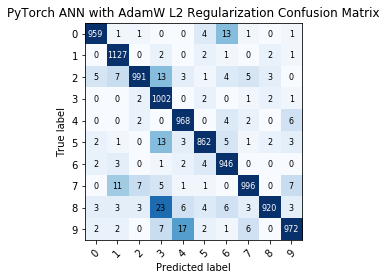

In [83]:
# ANN L2 Regularisation test results:

# Reload test dataset

ANN_train_dataset, ANN_test_dataset=transformed_data()
test_loader= DataLoader(ANN_test_dataset, batch_size=batch_size, shuffle=False) 

optimiser= torch.optim.AdamW(ANN_L2.parameters(),lr=learning_rate)

# Predict test set
ANN_L2_test_results, ANN_L2_predictions = predict(model=ANN_L2, test_loader=test_loader, device=device)

# Print results
print('Test loss for ANN is {}'.format(ANN_L2_test_results['test_loss']))
print('Test accuracy % for ANN is {}'.format((ANN_L2_test_results['test_accuracy']*100)))
print('Error rate % for ANN is {}'.format((1-ANN_L2_test_results['test_accuracy'])*100))

# Create and plot Confusion Matrix

ANN_L2_CM= confusion_matrix(ANN_L2_predictions, ANN_test_dataset) # requires predictions & test_dataset

fig=plot_confusion_matrix (ANN_L2_CM, "PyTorch ANN with AdamW L2 Regularization Confusion Matrix")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ANN_AdamW_Confusion_Matrix.jpg'), dpi=200);

#### CNN training and testing:

ConvNetwork(
  (conv_layer1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(20, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc_layer1): Linear(in_features=2000, out_features=512, bias=True)
  (fc_layer2): Linear(in_features=512, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 0, Training Loss: 0.2609, Validation Loss:0.0935, train_accuracy = 0.9230, val_accuracy = 0.9711
Epoch: 1, Training Loss: 0.0497, Validation Loss:0.0566, train_accuracy = 0.9851, val_accuracy = 0.9833
Epoch: 2, Training Loss: 0.0336, Validation Loss:0.0431, train_accuracy = 0.9896, val_accuracy = 0.9864
Epoch: 3, Training Loss: 0.0233, Validation Loss:0.0391, train_accuracy = 0.9927, val_accuracy = 0.9882
Epoch: 4, Training Loss: 0.0171, Validation Loss:0.0398, train_accuracy = 0.9940, val_accuracy = 0.9891
Epoch: 5, Training Loss: 0.0135, Validation Loss:0.0372, train_accuracy = 0.9957, val_accuracy = 0.9895
Epoch: 6, Training Lo

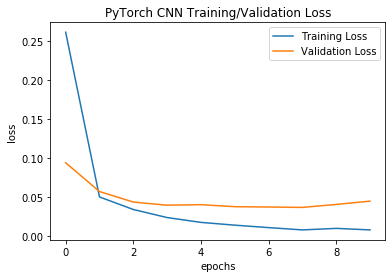

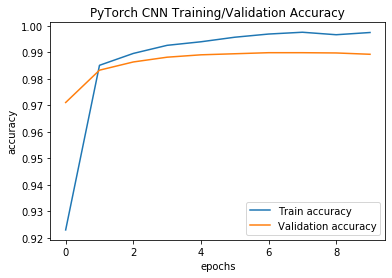

In [84]:
# Train PyTorch convolutional neural network class ConvNetwork to explore improvements in classification of MNIST:
# Use same architecture for classifier component as used for ANN test 2 to be able to compare appropriately.

# Instantiate the model and move to run on GPU:
torch.manual_seed(10)
# Specify the following parameters n_layer1, n_layer2, n_output, activation_functions,n_clayer1=20,n_clayer2=80 # Conv layers fixed
# Note: Input for fully connected layer comes directly from convolutional layer and we do not need to specify as we have fixed
#the Parameters for kernal size, stride and padding relevant to MNIST. We will not explore these parameters and so have not paratramized them.
model_Conv= ConvNetwork(512, 128, 10, activation_functions=['Sigmoid','ReLu']) 
model_Conv.to("cuda:0")
print(model_Conv)
      
# Set hyperparameters
batch_size=100 #Set batch size for loaders
loss_function= nn.CrossEntropyLoss()
learning_rate=0.001
optimiser= torch.optim.Adam(model_Conv.parameters(),lr=learning_rate)  
epochs=10
device= "cuda:0"
    
# Call transformed data
Conv_train_dataset, Conv_test_dataset=transformed_data()
    
# Create validation subset and set up the dataset loaders
train_subset, validation_subset = torch.utils.data.random_split(
        Conv_train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(10))
train_loader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
val_loader= DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
test_loader= DataLoader(Conv_test_dataset, batch_size=batch_size, shuffle=False) 

# Run Train/Validate for the instantiated model and record performance
# Set model, optimiser, loss_function, train_loader, val_loader, epochs, device
CNN_performance_history = train(model=model_Conv, optimiser=optimiser, loss_function=loss_function, train_loader=train_loader, val_loader=val_loader, 
              epochs=epochs, device=device)

# Plot loss and accuracy curves # requires history, title
fig=plot_train_loss(CNN_performance_history, "PyTorch CNN Training/Validation Loss")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_CNN_Training_Validation_Loss.jpg'), dpi=200)

fig=plot_train_accuracy(CNN_performance_history, "PyTorch CNN Training/Validation Accuracy")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_CNN_Training_Validation_Accuracy.jpg'), dpi=200)

plt.close;



C:\Users\sarah\anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Duration:4.917068243026733 seconds
Test loss for CNN is 0.03186436395359124
Test accuracy % for CNN is 99.13999938964844
Error rate % for CNN is 0.8599996566772461


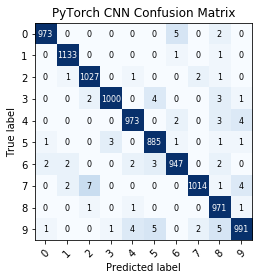

In [99]:
# CNN Test Results:

# Reload test dataset
# Call transformed data
Conv_train_dataset, Conv_test_dataset=transformed_data()
test_loader= DataLoader(Conv_test_dataset, batch_size=batch_size, shuffle=False)

# Predict test set
CNN_test_results, CNN_predictions = predict(model=model_Conv, test_loader=test_loader, device=device)
 
# # Print results
print('Test loss for CNN is {}'.format(CNN_test_results['test_loss']))
print('Test accuracy % for CNN is {}'.format((CNN_test_results['test_accuracy']*100)))
print('Error rate % for CNN is {}'.format((1-CNN_test_results['test_accuracy'])*100))

# Create and plot Confusion Matrix
CNN_CM= confusion_matrix(CNN_predictions, Conv_test_dataset) # requires predictions & test_dataset

fig=plot_confusion_matrix (CNN_CM, "PyTorch CNN Confusion Matrix")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_CNN_Confusion_Matrix.jpg'), dpi=200);

##### ResNet Test and Train:

Epoch: 0, Training Loss: 0.5230, Validation Loss:0.1731, train_accuracy = 0.9140, val_accuracy = 0.9780
Epoch: 1, Training Loss: 0.1433, Validation Loss:0.0936, train_accuracy = 0.9801, val_accuracy = 0.9858
Epoch: 2, Training Loss: 0.0891, Validation Loss:0.0649, train_accuracy = 0.9852, val_accuracy = 0.9873
Epoch: 3, Training Loss: 0.0670, Validation Loss:0.0525, train_accuracy = 0.9873, val_accuracy = 0.9878
Epoch: 4, Training Loss: 0.0537, Validation Loss:0.0446, train_accuracy = 0.9891, val_accuracy = 0.9898
Duration:777.8140032291412 seconds


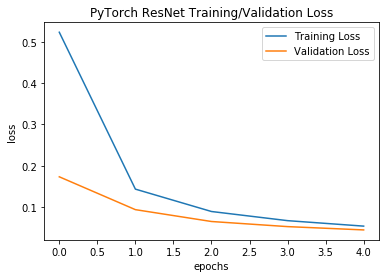

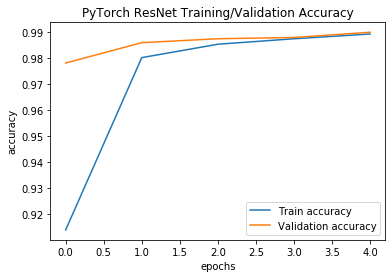

In [86]:
# Train ResNet pre-trained model loaded from PyTorch as an example of transfer learning as an improved model:
# Takes ~25mins to run
# Instantiate the model and move to run on GPU:
torch.manual_seed(10)


model_ResNet= ResNet # Parameters fixed relevant to MNIST

# Freeze layers, except batch normalised layers:
for name, param in model_ResNet.named_parameters():
    if ("bn" not in name):
        param.requires_grad=False
        
model_ResNet.to("cuda:0")
#print(ResNet)
      
# Set hyperparameters
batch_size=50 #Smaller batch size required compared to previously tested due to GPU memory
loss_function= nn.CrossEntropyLoss()
learning_rate=0.001
optimiser= torch.optim.Adam(model_ResNet.parameters(),lr=learning_rate)  
epochs=5 # lower number of epochs requires
device= "cuda:0"
    
# Call transformed data
ResNet_train_dataset, ResNet_test_dataset=transformed_data(resize=True)


# Create validation subset and set up the dataset loaders
train_subset, validation_subset = torch.utils.data.random_split(
        ResNet_train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(10))
train_loader= DataLoader(train_subset, batch_size=batch_size, shuffle=True) 
val_loader= DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
test_loader= DataLoader(ResNet_test_dataset, batch_size=batch_size, shuffle=False) 

# Run Train/Validate for the instantiated model and record performance
# Set model, optimiser, loss_function, train_loader, val_loader, epochs, device
ResNet_performance_history = train(model=model_ResNet, optimiser=optimiser, loss_function=loss_function, train_loader=train_loader, val_loader=val_loader, 
              epochs=epochs, device=device)

# Plot loss and accuracy curves # requires history, title
fig=plot_train_loss(ResNet_performance_history, "PyTorch ResNet Training/Validation Loss")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ResNet_Training_Validation_Loss.jpg'), dpi=200)

fig=plot_train_accuracy(ResNet_performance_history, "PyTorch ResNet Training/Validation Accuracy")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ResNet_Training_Validation_Accuracy.jpg'), dpi=200)

plt.close;



Duration:16.730029106140137 seconds
Test loss for CNN is 0.040989416441880165
Test accuracy % for CNN is 99.10999298095703
Error rate % for CNN is 0.8900046348571777


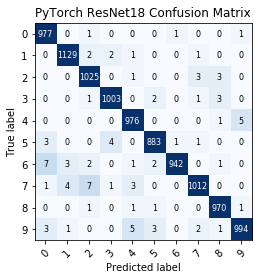

In [87]:
#ResNet test results:
    
#Reload test dataset
ResNet_train_dataset, ResNet_test_dataset=transformed_data(resize=True)

# Predict test set
batch_size=50
test_loader= DataLoader(ResNet_test_dataset, batch_size=batch_size, shuffle=False)
ResNet_test_results, ResNet_predictions = predict(model=model_ResNet, test_loader=test_loader, device=device)


# # Print results
print('Test loss for CNN is {}'.format(ResNet_test_results['test_loss']))
print('Test accuracy % for CNN is {}'.format((ResNet_test_results['test_accuracy']*100)))
print('Error rate % for CNN is {}'.format((1-ResNet_test_results['test_accuracy'])*100))

# Create and plot Confusion Matrix
ResNet_CM= confusion_matrix(ResNet_predictions, ResNet_test_dataset) # requires predictions & test_dataset
fig=plot_confusion_matrix (ResNet_CM, "PyTorch ResNet18 Confusion Matrix")
#fig.savefig(os.path.join(path, r'Figures\Task3\PyTorch_ResNet18_Confusion_Matrix.jpg'), dpi=200);